## Init

In [ ]:
# Load the Drive helper and mount:
from google.colab import drive

# This will prompt for authorization:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import tensorflow as tf
import gc
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from keras.metrics import MeanIoU
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
import matplotlib.colors
import pandas as pd
from keras.models import load_model
from tensorflow.keras import layers
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_pre
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.densenet import preprocess_input as densenet_pre
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_pre
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_pre
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnetv2_pre
from tensorflow.keras.applications import EfficientNetV2L



from keras.utils import plot_model
from keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def get_poolings(target_size, in_shape):

    if target_size > in_shape[-1]:
        min_dims = int(target_size / in_shape[-1])
        pool_2d = int(np.log(in_shape[2] / min_dims) / np.log(2))
        prod = in_shape[1] * min_dims * min_dims
        pool_1d = int(np.log(prod / target_size) / np.log(2))

    else:
        pool_2d = int(np.log(in_shape[2]) / np.log(2))
        pool_1d = int(np.log(in_shape[-1] / target_size) / np.log(2))

    return pool_2d, pool_1d

In [ ]:
def load_image(image_path):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return np.array(image)

In [ ]:
def get_elements(a, b):
    return [a[i] for i in b]

def skin_acc(preds, trues):
    goods = 0
    for pred, gt in zip(preds, trues):
        if gt == 1:
            if pred > 0.5:
                goods += 1
        else:
            if pred <= 0.5:
                goods += 1
    return goods / len(preds)

In [ ]:
def prepare_data(split, image_dir, df, preprocess_input, size=(256,256), batches=30):

    # Create an ImageDataGenerator for the images
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Generate the training data

    if split == 'test':
        # Generate the testing data
        generator = datagen.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col='DDI_file',
            y_col='malignant',
            class_mode='binary',
            target_size=size,
            batch_size=batches,
            shuffle=False
        )

        light = []
        med = []
        dark = []
        ctr = 0

        for i, row in df.iterrows():
            fn = str(row['DDI_file'])
            tone = int(row['skin_tone'])
            if fn in os.listdir(image_dir):
                if tone == 12:
                    light.append(ctr)
                elif tone == 34:
                    med.append(ctr)
                else:
                    dark.append(ctr)
                ctr += 1

        return generator, light, med, dark

    else:
        # Train/Val data
        generator = datagen.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col='DDI_file',
            y_col='malignant',
            class_mode='binary',
            target_size=size,
            batch_size=batches
        )

        return generator

## One off

In [ ]:
frac = 20
fold = 0
zoom = "Resized"
base = f"/content/drive/MyDrive/Winter 2023/DDI/Classification/{zoom}"

df = pd.read_csv(opts['metadata_path'])
df['malignant'] = df['malignant'].astype(str)

opts = {
    "metadata_path": '/content/drive/MyDrive/Winter 2023/DDI/ddi_metadata.csv',
    "training_path": f"{base}/Fold {fold}/{frac}%/train",
    "validation_path": f"{base}/Fold {fold}/{frac}%/val",
    "testing_path": f"{base}/Fold {fold}/{frac}%/test",
}

In [ ]:
df = pd.read_csv(opts['metadata_path'])

In [ ]:
df['malignant'] = df['malignant'].astype(str)

In [ ]:
train_generator = prepare_data('train', opts['training_path'], vgg16_pre)
val_generator = prepare_data('val', opts['validation_path'], vgg16_pre)
test_generator = prepare_data('test', opts['testing_path'], vgg16_pre)

Found 30 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.


In [ ]:
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

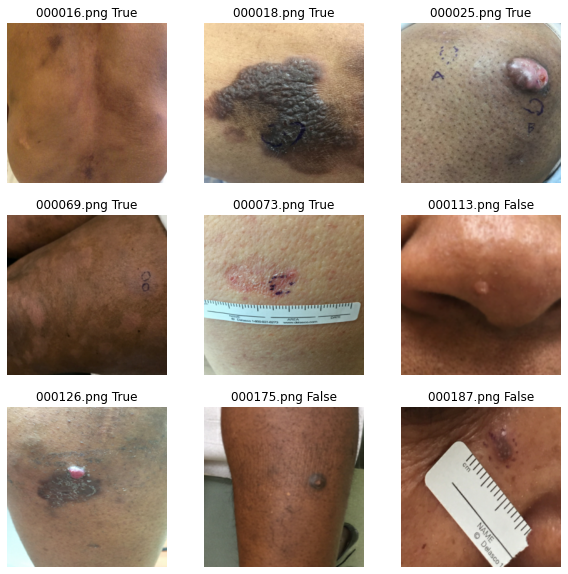

In [ ]:
plt.figure(figsize=(10, 10))
i = 0
for image, label in zip(train_generator.filenames, train_generator.classes):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(load_image(os.path.join(opts['training_path'], image)))
    plt.title(image + " " + class_names[label])
    plt.axis("off")
    i += 1
    if i == 9:
        break

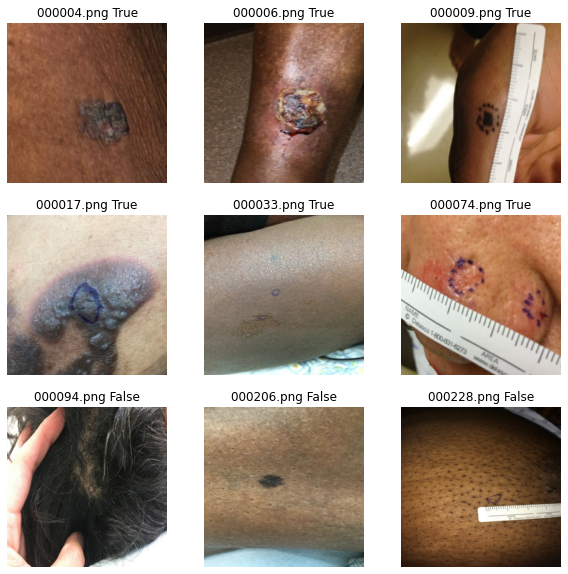

In [ ]:
class_names = val_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

plt.figure(figsize=(10, 10))
i = 0
for image, label in zip(val_generator.filenames, val_generator.classes):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(load_image(os.path.join(opts['validation_path'], image)))
    plt.title(image + " " + class_names[label])
    plt.axis("off")
    i += 1
    if i == 9:
        break

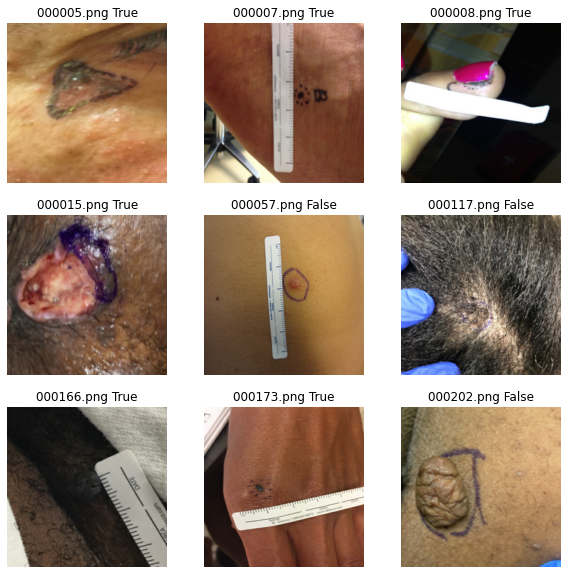

In [ ]:
class_names = test_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

plt.figure(figsize=(10, 10))
i = 0
for image, label in zip(test_generator.filenames, test_generator.classes):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(load_image(os.path.join(opts['testing_path'], image)))
    plt.title(image + " " + class_names[label])
    plt.axis("off")
    i += 1
    if i == 9:
        break

In [ ]:
train_generator = prepare_data('train', opts['training_path'], vgg16_pre)
val_generator = prepare_data('val', opts['validation_path'], vgg16_pre)
test_generator = prepare_data('test', opts['testing_path'], vgg16_pre)

Found 120 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 536 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.


In [ ]:
BACKBONE = 'VGG16'

In [ ]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

In [ ]:
model.trainable = False

In [ ]:
small_diff_vector_size = 2048

In [ ]:
x = model.output
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
classifier = keras.Model(inputs=model.input, outputs=x)

In [ ]:
classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
classifier.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"])

In [ ]:
save_path = f"/content/drive/MyDrive/Winter 2023/DDPM/pixel_classifiers/cnn/{BACKBONE}/{zoom}/Fold {fold}/{frac}%/"
best_model_path = os.path.join(save_path, "final_model.hdf5")

earlystop = EarlyStopping(monitor = 'val_accuracy',
                        mode = "max",
                        min_delta = 0,
                        patience = 100,
                        verbose = 1,
                        restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                            mode = "max",
                            factor = 0.1,
                            patience = 50,
                            min_lr = 0.00001,
                            verbose = 1)

tensor_board = tbCallBack = TensorBoard(log_dir = os.path.join(save_path, 'logs/'),
                                        histogram_freq = 0,
                                        write_graph = True,
                                        write_images = False)

In [ ]:
callback_list = [reduce_lr, earlystop, tensor_board]

history = classifier.fit(train_generator,
                        epochs=10000,
                        verbose=1,
                        validation_data=val_generator,
                        callbacks = callback_list)

Epoch 1/10000
4/4 [==============================] - 30s 7s/step - loss: 0.8979 - accuracy: 0.5167 - val_loss: 2.6495 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/10000
4/4 [==============================] - 1s 335ms/step - loss: 0.6340 - accuracy: 0.6667 - val_loss: 2.3255 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 3/10000
4/4 [==============================] - 2s 456ms/step - loss: 0.6492 - accuracy: 0.6167 - val_loss: 2.0222 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 4/10000
4/4 [==============================] - 2s 405ms/step - loss: 0.5837 - accuracy: 0.7000 - val_loss: 1.6915 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 5/10000
4/4 [==============================] - 1s 345ms/step - loss: 0.6172 - accuracy: 0.7167 - val_loss: 1.4064 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 6/10000
4/4 [==============================] - 1s 377ms/step - loss: 0.5021 - accuracy: 0.7750 - val_loss: 1.2161 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/10000
4/4 [==============================] - 1s 334ms/step

In [ ]:
classifier.save(best_model_path, overwrite=True)

## Experiment loop

In [ ]:
from tqdm.auto import tqdm

In [ ]:
fracs = [5, 10, 15, 20]
embedding_size = 512
backbones = [VGG16, MobileNetV2, EfficientNetB0, ResNet50, DenseNet121, EfficientNetV2L]
backbone_names = ['vgg16', 'mobilenetv2','efficientnetb0', 'resnet50', 'densenet121', 'efficientnetv2l']
act = 'relu'
fold = 3
zoom = "Resized"
base = f"/content/drive/MyDrive/Winter 2023/DDI/Classification/{zoom}"


exp_table_path = os.path.join("/content/drive/MyDrive/Winter 2023/DDPM/",
                              "experiments_cnn_classifiers_v2.csv")

try:
    experiment_table = pd.read_csv(exp_table_path)

except:
    headers = {"Method":[], "DDI Fraction (%)":[], "Fold":[], "Zoom":[],
               "Image Size":[], "Diffusion Timesteps":[], "Blocks":[],
               "Dense Layers":[], "Dropout":[], "L2 Penalty":[], "Raw Embedding":[],
               "Pooling Layers":[], "Final Embedding Size":[],

               "Train Accuracy":[], "Val Accuracy":[], "Test Accuracy":[],

               "Results":[]}

    table = pd.DataFrame.from_dict(headers)
    table.to_csv(exp_table_path, index=False)
    experiment_table = pd.read_csv(exp_table_path)

i = 5
for backbone in tqdm(backbones[i:]):

    if backbone == VGG16:
        pre_processing = vgg16_pre
    elif backbone == MobileNetV2:
        pre_processing = mobile_pre
    elif backbone == EfficientNetB0:
        pre_processing = efficientnet_pre
    elif backbone == ResNet50:
        pre_processing = resnet_pre
    elif backbone == DenseNet121:
        pre_processing = densenet_pre
    elif backbone == EfficientNetV2L:
        pre_processing = efficientnetv2_pre


    for frac in tqdm(fracs):
        gc.collect()

        opts = {
            "metadata_path": '/content/drive/MyDrive/Winter 2023/DDI/ddi_metadata.csv',
            "training_path": f"{base}/Fold {fold}/{frac}%/train",
            "validation_path": f"{base}/Fold {fold}/{frac}%/val",
            "testing_path": f"{base}/Fold {fold}/{frac}%/test",
        }

        df = pd.read_csv(opts['metadata_path'])
        df['malignant'] = df['malignant'].astype(str)

        train_generator = prepare_data('train', opts['training_path'], pre_processing)
        val_generator = prepare_data('val', opts['validation_path'], pre_processing)
        test_generator = prepare_data('test', opts['testing_path'], pre_processing)

        encoder = backbone(weights='imagenet', include_top=False,
                           input_shape=(256,256,3))
        encoder.trainable = False

        pool_2d, pool_1d = get_poolings(embedding_size, encoder.output.shape)

        x = encoder.output

        for _ in range(pool_2d):
            x = layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

        x = layers.Flatten()(x)

        x = tf.reshape(x, (-1, x.shape[1], 1))

        for _ in range(pool_1d):
            x = layers.MaxPool1D(pool_size=2, strides=2)(x)

        x = layers.Flatten()(x)

        embedding_size_actual = x.shape[-1]

        x = layers.Dense(64)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(act)(x) # currently relu try others?
        x = layers.Dropout(0.5)(x)

        x = layers.Dense(32)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(act)(x) # currently relu try others?
        x = layers.Dropout(0.25)(x)

        output = layers.Dense(1, activation='sigmoid')(x)

        model = Model(inputs=encoder.input, outputs=output)
        #model.summary()

        model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001),
                      metrics=["binary_accuracy"])


        save_path = f"/content/drive/MyDrive/Winter 2023/DDPM/pixel_classifiers/cnn_v2/{backbone_names[i]}/{zoom}/Fold {fold}/{frac}%/"
        best_model_path = os.path.join(save_path, "final_model.h5")

        earlystop = EarlyStopping(monitor = 'val_binary_accuracy',
                        mode = "max",
                        min_delta = 0,
                        patience = 50,
                        verbose = 1,
                        restore_best_weights = True)

        reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy',
                                    mode = "max",
                                    factor = 0.1,
                                    patience = 25,
                                    min_lr = 0.00001,
                                    verbose = 1)

        best_model = ModelCheckpoint(best_model_path,
                                    monitor = 'val_binary_accuracy',
                                    mode = 'max',
                                    verbose = 1,
                                    save_best_only = True)

        tensor_board = TensorBoard(log_dir = os.path.join(save_path, 'logs/'),
                                   histogram_freq = 0,
                                   write_graph = True,
                                   write_images = False)

        callback_list = [reduce_lr, earlystop, best_model, tensor_board]

        history = model.fit(train_generator,
                            epochs=500,
                            verbose=0,
                            validation_data=val_generator,
                            callbacks = callback_list)

        test_loss, test_acc = model.evaluate(test_generator)
        val_loss, val_acc = model.evaluate(val_generator)
        train_loss, train_acc = model.evaluate(train_generator)

        experiment_table.loc[len(experiment_table)] = [backbone_names[i], frac, fold,
                                                zoom, '[256, 256]', 'N/A', 'N/A',
                                                3, "[0.5, 0.25]", "N/A", encoder.output.shape,
                                                np.sum([pool_2d, pool_1d]), embedding_size_actual,
                                                train_acc, val_acc,
                                                test_acc, save_path]

        experiment_table.to_csv(exp_table_path, index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Found 30 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping
1/1 [==============================] - 1s 670ms/step - loss: 2.2385 - binary_accuracy: 0.5000
Found 60 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 596 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.
Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping
2/2 [==============================] - 1s 469ms/step - loss: 0.8288 - binary_accuracy: 0.4000
Found 90 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 566 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.
Restoring model weights from the end of the best epoch: 18.
Epoch 68: early stopping
3/3 [==============================] - 2s 453ms/step - loss: 0.7050 - binary_accuracy: 0.5556
Found 120 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 536 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.
Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping
4/4 [==============================] - 2s 448ms/step - loss: 0.7009 - binary_accuracy: 0.5000


## Metric Collection

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 26s 821ms/step
Best threshold: 1.00
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 12s 699ms/step
Best threshold: 0.74
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 11s 621ms/step
Best threshold: 0.58
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 10s 568ms/step
Best threshold: 1.00


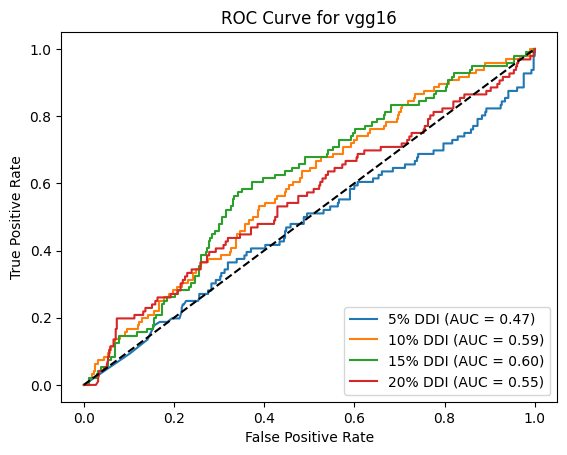

  0%|          | 0/4 [00:00<?, ?it/s]

Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 11s 555ms/step
Best threshold: 0.43
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 11s 602ms/step
Best threshold: 0.56
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 11s 593ms/step
Best threshold: 0.38
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 10s 539ms/step
Best threshold: 0.51


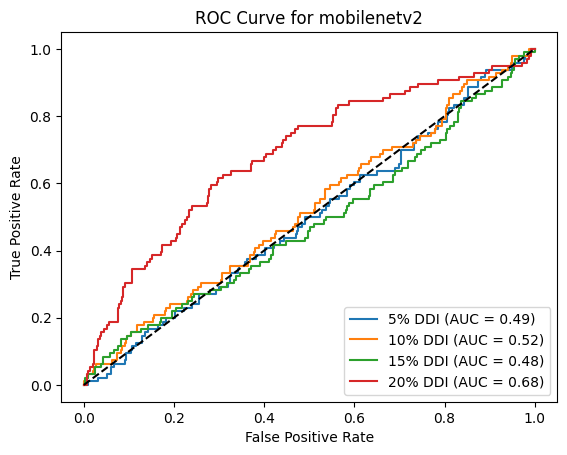

  0%|          | 0/4 [00:00<?, ?it/s]

Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 12s 607ms/step
Best threshold: 0.01
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 10s 525ms/step
Best threshold: 0.22
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 12s 620ms/step
Best threshold: 0.54
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 12s 603ms/step
Best threshold: 0.39


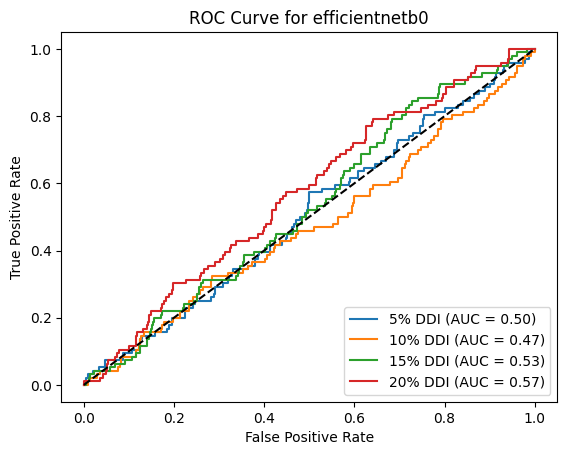

  0%|          | 0/4 [00:00<?, ?it/s]

Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 14s 677ms/step
Best threshold: 0.61
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 11s 577ms/step
Best threshold: 0.35
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 11s 631ms/step
Best threshold: 0.78
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 12s 607ms/step
Best threshold: 0.55


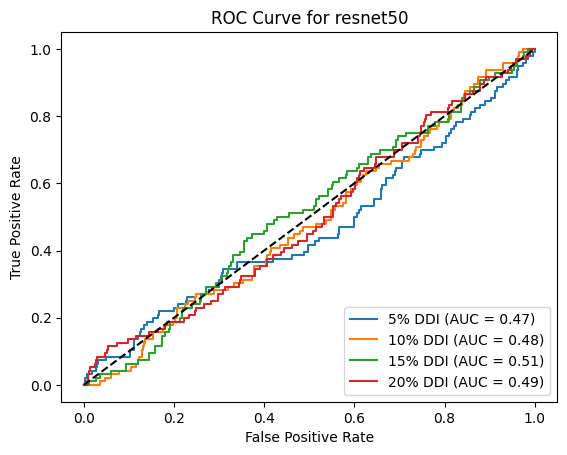

  0%|          | 0/4 [00:00<?, ?it/s]

Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 16s 706ms/step
Best threshold: 0.93
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 12s 593ms/step
Best threshold: 0.21
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 12s 634ms/step
Best threshold: 0.42
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


17/17 [==============================] - 12s 618ms/step
Best threshold: 0.52


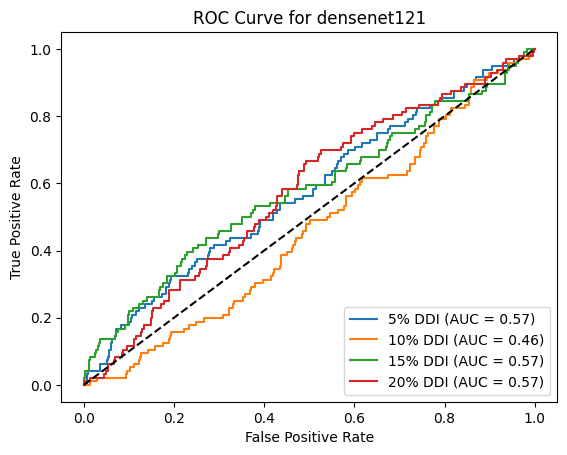

In [ ]:
fracs = [5, 10, 15, 20]
embedding_size = 512
backbones = [VGG16, MobileNetV2, EfficientNetB0, ResNet50, DenseNet121]
backbone_names = ['vgg16', 'mobilenetv2','efficientnetb0', 'resnet50', 'densenet121']
act = 'relu'
fold = 3
zoom = "Resized"
base = f"/content/drive/MyDrive/Winter 2023/DDI/Segmentation Labels/{zoom}/Rebuttal"


exp_table_path = os.path.join("/content/drive/MyDrive/Winter 2023/DDPM/",
                              "CLS_Rebuttal_2.csv")

try:
    experiment_table = pd.read_csv(exp_table_path)

except:
    headers = {"Method":[], "DDI Fraction (%)":[], "Block": [], "Timestep": [],
               "Best Threshold":[], "Overall ROC-AUC":[], "Light ROC-AUC":[],
               "Med ROC-AUC":[], "Dark ROC-AUC":[], "F1":[], "Light F1":[],
               "Med F1":[], "Dark F1":[], "Overall Acc (%)":[],
               "Light Acc (%)":[], "Med Acc (%)":[], "Dark Acc (%)":[]}

    table = pd.DataFrame.from_dict(headers)
    table.to_csv(exp_table_path, index=False)
    experiment_table = pd.read_csv(exp_table_path)

for i, backbone in enumerate(tqdm(backbones)):

    if backbone == VGG16:
        pre_processing = vgg16_pre
    elif backbone == MobileNetV2:
        pre_processing = mobile_pre
    elif backbone == EfficientNetB0:
        pre_processing = efficientnet_pre
    elif backbone == ResNet50:
        pre_processing = resnet_pre
    elif backbone == DenseNet121:
        pre_processing = densenet_pre
    elif backbone == EfficientNetV2L:
        pre_processing = efficientnetv2_pre

    for frac in tqdm(fracs):
        gc.collect()

        opts = {
            "metadata_path": '/content/drive/MyDrive/Winter 2023/DDI/ddi_metadata.csv',
            "testing_path": f"{base}/Fold {fold}/cls_test", # contains all images not in train/val of 20%
        }

        df = pd.read_csv(opts['metadata_path'])
        df['malignant'] = df['malignant'].astype(str)

        test_generator, light_idx, med_idx, dark_idx = prepare_data('test', opts['testing_path'], df, pre_processing)

        save_path = f"/content/drive/MyDrive/Winter 2023/DDPM/pixel_classifiers/cnn_v2/{backbone_names[i]}/{zoom}/Fold {fold}/{frac}%/"
        best_model_path = os.path.join(save_path, "final_model.h5")

        model = keras.models.load_model(best_model_path)

        y_pred_prob = model.predict(test_generator)
        y_true = test_generator.classes

        test_acc = skin_acc(y_pred_prob.flatten(), y_true)

        dark_trues = get_elements(y_true, dark_idx)
        dark_preds = get_elements(y_pred_prob.flatten(), dark_idx)
        dark_acc = skin_acc(dark_preds, dark_trues)

        med_trues = get_elements(y_true, med_idx)
        med_preds = get_elements(y_pred_prob.flatten(), med_idx)
        med_acc = skin_acc(med_preds, med_trues)

        light_trues = get_elements(y_true, light_idx)
        light_preds = get_elements(y_pred_prob.flatten(), light_idx)
        light_acc = skin_acc(light_preds, light_trues)

        fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
        auc = roc_auc_score(y_true, y_pred_prob)

        light_auc = roc_auc_score(light_trues, light_preds)
        med_auc = roc_auc_score(med_trues, med_preds)
        dark_auc = roc_auc_score(dark_trues, dark_preds)

        plt.plot(fpr, tpr, label=f'{frac}%% DDI (AUC = %0.2f)' % auc)

        best_threshold = 0
        best_diff = 0
        for j in range(len(thresholds)):
            diff = tpr[j] - fpr[j]
            if diff > best_diff:
                best_diff = diff
                best_threshold = thresholds[j]
        print('Best threshold: %0.2f' % best_threshold)

        y_pred_bin = [int(p > best_threshold) for p in y_pred_prob]
        f1 = f1_score(y_true, y_pred_bin)

        y_pred_bin_light = [int(p > best_threshold) for p in light_preds]
        light_f1 = f1_score(light_trues, y_pred_bin_light)

        y_pred_bin_med = [int(p > best_threshold) for p in med_preds]
        med_f1 = f1_score(med_trues, y_pred_bin_med)

        y_pred_bin_dark = [int(p > best_threshold) for p in dark_preds]
        dark_f1 = f1_score(dark_trues, y_pred_bin_dark)

        experiment_table.loc[len(experiment_table)] = [backbone_names[i], frac,
                                                       "N/A", "N/A", best_threshold, auc,
                                                        light_auc, med_auc, dark_auc,
                                                        f1, light_f1, med_f1, dark_f1,
                                                        test_acc, light_acc,
                                                        med_acc, dark_acc]

        experiment_table.to_csv(exp_table_path, index=False)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title = f'ROC Curve for {backbone_names[i]}'
    plt.title(title)
    plt.legend(loc='lower right')
    plt.savefig(save_path + title + ".pdf")
    plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()